In this notebook, we'll look at the daily number of confirmed, deaths, and recovered statistics in the United States. The number of data points is relatively small (~1k), so we can consider a fair range of regression techniques for this problem. 

First, let's import the necessary libraries and set a random seed.

In [185]:
# base libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

# sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, Matern
from sklearn.metrics import mean_squared_error as mse, r2_score as R2
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# others
from tqdm import tqdm

# set rng seed
rng_seed = 0
np.random.seed(rng_seed)

Now let's load the dataset:

In [2]:
df = pd.read_csv('us_df.csv')
# ensure that 'updated' times are interpreted as pandas datetimes (and not strs)
df['updated'] = pd.to_datetime( df['updated'] )

## Analysis

Let's look at the confirmed, deaths, and recovered statistics:

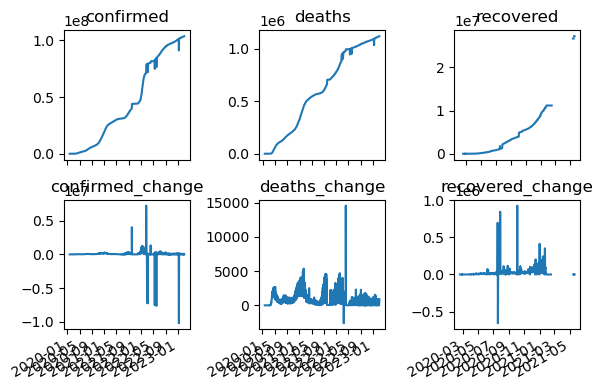

In [15]:
cols = ['confirmed','deaths','recovered',
        'confirmed_change','deaths_change','recovered_change']
fig, axes = plt.subplots(2,3, figsize=(6,4))
axes1d = axes.flatten()
for i, col in enumerate(cols):
    axes1d[i].plot( df['updated'], df[col] )
    axes1d[i].set_title(col)
fig.autofmt_xdate()
fig.tight_layout()

There are some weird trends and bumps in the confirmed and death columns, but the recovered columns only show a fraction of the data relative to the others. Let's count the data availability:

In [4]:
df[cols].isna().sum(axis=0) / df.shape[0]

confirmed           0.000000
deaths              0.000000
recovered           0.634314
confirmed_change    0.000980
deaths_change       0.007843
recovered_change    0.642157
dtype: float64

The confirmed and deaths columns have no missing values, but their changes have 0.1% and 0.8% NaNs respectively. However, the recovered and recovered_change columns have over 60% missing data! So we can work with the confirmed and deaths data, but the recovered data is practically unusable here.

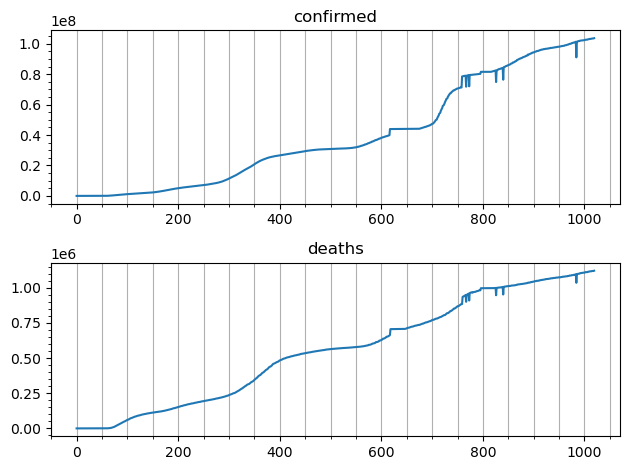

In [5]:
fig, axes = plt.subplots(2,1)
cols = ['confirmed','deaths']
for i, col in enumerate(cols):
    axes[i].plot( df[col] )
    axes[i].grid(which='both',axis='x')
    axes[i].minorticks_on()
    axes[i].set_title(col)
fig.tight_layout()

The overall curve is largely okay, but there are clearly some weird values... a plateau from around row index 620 to 675, a huge jump just after 750, and sharp single-time drops occuring throughout after that in the confirmed column (the deaths lines up with these, but is slightly shifted to due to 1% missing data). We'll look at these more closely:

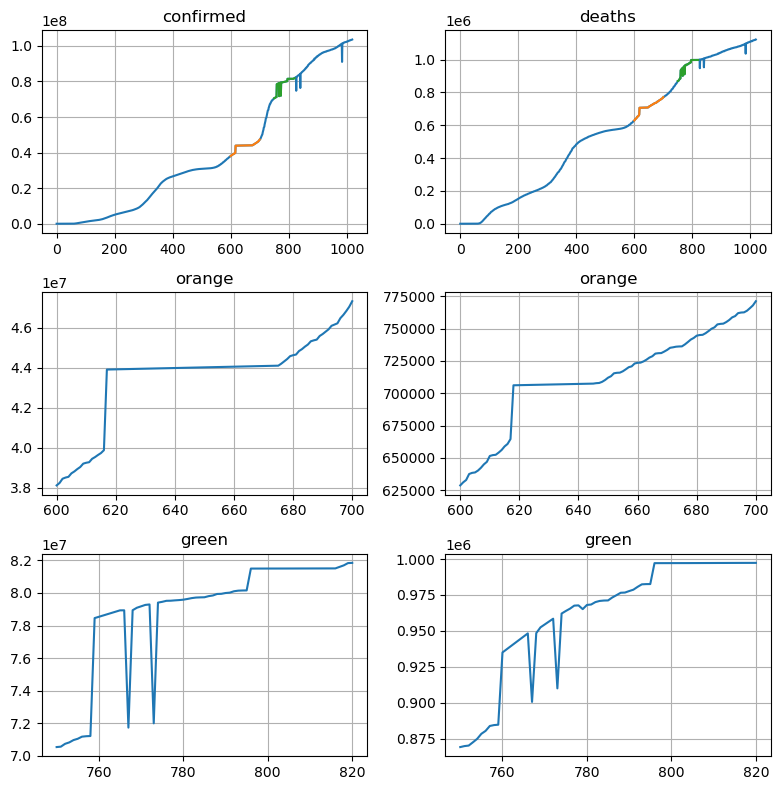

In [6]:
idxs1 = np.arange(600,700+1)
idxs2 = np.arange(750,820+1)
fig, axes = plt.subplots(3,2,figsize=(8,8))
for i, col in enumerate(cols):
    ax_row = axes.T[i]
    ax_row[0].plot( df[col] )
    ax_row[0].plot( df.iloc[idxs1][col])
    ax_row[0].plot( df.iloc[idxs2][col])
    ax_row[1].set_title( 'orange' )
    ax_row[1].plot( df.iloc[idxs1][col])
    ax_row[2].set_title( 'green' )
    ax_row[2].plot( df.iloc[idxs2][col])
    ax_row[0].set_title(col)
for ax in axes.flatten():
    ax.grid(which='major')
fig.tight_layout()

This will definitely be an issue for getting accurate predictions, so we should clean this data before doing anything. Let's look at the columns for confirmed_change and deaths_change to see how these strange confirmed and deaths values correlated with the change columns.

In [7]:
with pd.option_context('display.max_rows', 101):
    display(
           df.iloc[idxs1][['updated','confirmed','confirmed_change','deaths','deaths_change']]
    )

,updated,confirmed,confirmed_change,deaths,deaths_change
600,2021-09-14,38110172,140371.0,628678.0,2040.0
601,2021-09-15,38233523,123351.0,631060.0,2382.0
602,2021-09-16,38443734,210211.0,632874.0,1814.0
603,2021-09-17,38502621,58887.0,637479.0,4605.0
604,2021-09-18,38538826,36205.0,638368.0,889.0
605,2021-09-19,38713438,174612.0,638701.0,333.0
606,2021-09-20,38808930,95492.0,640164.0,1463.0
607,2021-09-21,38927960,119030.0,642313.0,2149.0
608,2021-09-22,39031871,103911.0,644957.0,2644.0
609,2021-09-23,39199103,167232.0,646900.0,1943.0


In [8]:
with pd.option_context('display.max_rows', 101):
    display(
           df.iloc[idxs2][['updated','confirmed','confirmed_change','deaths','deaths_change']]
    )

,updated,confirmed,confirmed_change,deaths,deaths_change
750,2022-02-11,70542149,41377.0,869054.0,3748.0
751,2022-02-12,70567389,25240.0,869735.0,681.0
752,2022-02-13,70741215,173826.0,870095.0,360.0
753,2022-02-14,70828575,87360.0,872385.0,2290.0
754,2022-02-15,70971781,143206.0,874755.0,2370.0
755,2022-02-16,71050716,78935.0,878289.0,3534.0
756,2022-02-17,71180629,129913.0,880328.0,2039.0
757,2022-02-18,71207823,27194.0,883741.0,3413.0
758,2022-02-19,71220709,12886.0,884368.0,627.0
759,2022-02-20,78457081,7236372.0,884619.0,251.0


Okay, so it's a little bit clearer now - there's some insight given by indices 771 to 775, specifically:

In [9]:
df.iloc[np.arange(758,769+1)][['updated','confirmed','confirmed_change','deaths','deaths_change']]

,updated,confirmed,confirmed_change,deaths,deaths_change
758,2022-02-19,71220709,12886.0,884368.0,627.0
759,2022-02-20,78457081,7236372.0,884619.0,251.0
760,2022-02-21,78536190,79109.0,934951.0,NaN
761,2022-02-22,78615299,79109.0,937161.0,2210.0
762,2022-02-23,78694409,79110.0,939371.0,2210.0
763,2022-02-24,78773519,79110.0,941582.0,2211.0
764,2022-02-25,78852629,79110.0,943793.0,2211.0
765,2022-02-26,78931739,79110.0,946004.0,2211.0
766,2022-02-27,78934227,2488.0,948215.0,2211.0
767,2022-03-01,71735729,-7196010.0,900506.0,NaN


It seems like negative numbers are placed into the confirmed_change column to try to account for likely erroneous previous entries, such as with rows 767 vs 759 above... but this new count is not reflected in subsequent entries. These negative entries seem to occur on days after a missing entry as well.

Given this and the fact that the data seems relatively continuous after some of the spikes the jump, we'll deal with this in the following way: Data corresponding to sudden spikes as well as linearly constant increases should be removed, but intervals that are relatively continuous should be kept. For example, the 'green' plot of the confirmed cases above shows both some intervals to remove (row indices 759 to 773 and 796 to 826) as well as an interval to preserve (774 to 795).

## Goal:

We'll try to replace the data in the gaps using different regression techniques.

## Pre-processing

Looking through the dataset manually, here's the points that should be removed. The majority of point belong to long interavals, but there are sporadic 2-point intervals that consist of exactly repeating numbers.

In [23]:
bad_idxs = np.hstack([ 
    np.arange(617,675+1),
    np.arange(759,773+1), 
    np.arange(796,826+1), 
    840,
    np.arange(887,888+1),
    np.arange(892,896+1),
    np.arange(945,946+1),
    np.arange(965,966+1),
    984 
])

keep_idxs = np.setdiff1d( np.arange(df.shape[0]), bad_idxs )
kept_df = df.iloc[keep_idxs]

Now after removing those points, we should also try to bring the dataset to a constant time resolution. From the histogram of consecutive time differences (in days) below, there are a few points with delta_t > 1 beyond those we created from the removal.

10.5% of data has time-skip > 1 day


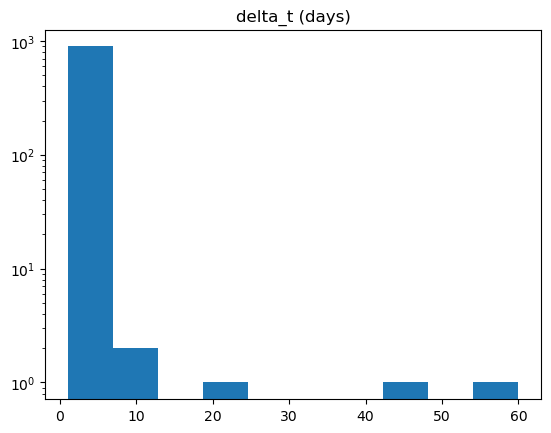

In [24]:
delta_t = (kept_df['updated'].values[1:] - kept_df['updated'].values[:-1]) / pd.Timedelta('1 day')
fig, ax = plt.subplots(1,1)
ax.hist( delta_t, log=True )
ax.set_title('delta_t (days)')
print( f'{100*(delta_t > 1).sum() / delta_t.shape[0]:.1f}% of data has time-skip > 1 day' )

We'll insert all the missing days into the dataset and record their values as NaNs:

In [37]:
times_pd = pd.to_datetime( df['updated'].values )
dates_df = pd.DataFrame( {'updated' : pd.date_range(times_pd[0], times_pd[-1], freq='D') } )
kept_cols = ['updated', 'confirmed', 'deaths']
merged_df = pd.merge(dates_df, kept_df[kept_cols], on='updated', how='left')

# get counts of nans
merged_df.isna().sum(axis=0) / merged_df.shape[0]
print(f'Went from {df.shape[0]} rows (original)'
      f' to {kept_df.shape[0]} (post-removal)'
      f' to {merged_df.shape[0]} (after merging).')

Went from 1020 rows (original) to 902 (post-removal) to 1137 (after merging).


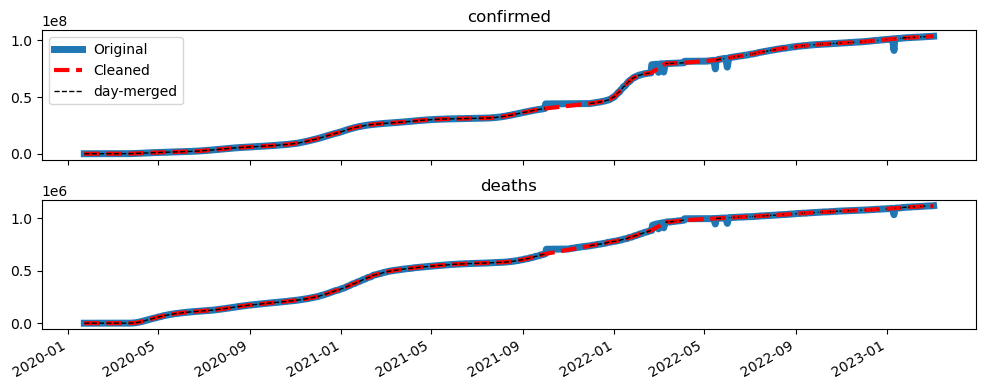

In [106]:
fig, axes = plt.subplots(2,1, figsize=(10,4))
cols = ['confirmed','deaths']
for i, col in enumerate(cols):
    axes[i].plot( df['updated'], df[col], ls='solid', lw=5, label='Original' )
    axes[i].plot( kept_df['updated'], kept_df[col], ls='dashed', c='red', lw=3, label='Cleaned'  )
    axes[i].plot( merged_df['updated'], merged_df[col], ls='dashed', c='black', lw=1, label='day-merged' )
    axes[i].set_title(col)
axes[0].legend()
fig.autofmt_xdate()
fig.tight_layout()

A lot cleaner. Now we can proceed with the regression tasks.

## Regression

We'll have two tasks for regression going forward. One of course is the MSE on the data we have, and the other is the model's ability to impute the missing data well (which will have to be "by-eye"). We will not have a train-test split here, but the real goal is to get a good imputation on the missing data (for which we have no y)! So for these models, we'll generally see decreasing MSE with increasing model complexity, but note that these would begin to overfit!

Let's prepare the input and output data (along with standardization)

In [131]:
# get masks for nan and not-nan data
na_mask = merged_df['confirmed'].isna()
not_na_mask = ~na_mask

# build X and y for both not-nan and full data
not_na_times = merged_df['updated'][not_na_mask]
not_na_X = merged_df[not_na_mask].index.values.reshape(-1,1)
full_X = merged_df.index.values.reshape(-1,1)
full_times = merged_df['updated']
not_na_y = merged_df['confirmed'][not_na_mask].values

# get scaled X and y - note that scaler is trained on FULL x!
X_scaler = StandardScaler().fit(full_X)
not_na_X_scaled = X_scaler.transform(not_na_X)
full_X_scaled = X_scaler.transform(full_X)
y_scaler = StandardScaler().fit(not_na_y.reshape(-1,1))
not_na_y_scaled = y_scaler.transform(not_na_y.reshape(-1,1)).flatten()

# get scaled versions for original bad data
orig_times = df['updated']
orig_y_scaled = y_scaler.transform( df[['confirmed']].values ).flatten()

Let's first go with polynomial regression (or multivariate linear regression on the polynomial features [e.g. $X$, $X^2$, $X^3$, ...])  and see the performance with increasing polynomial order:

### Polynomial Regression

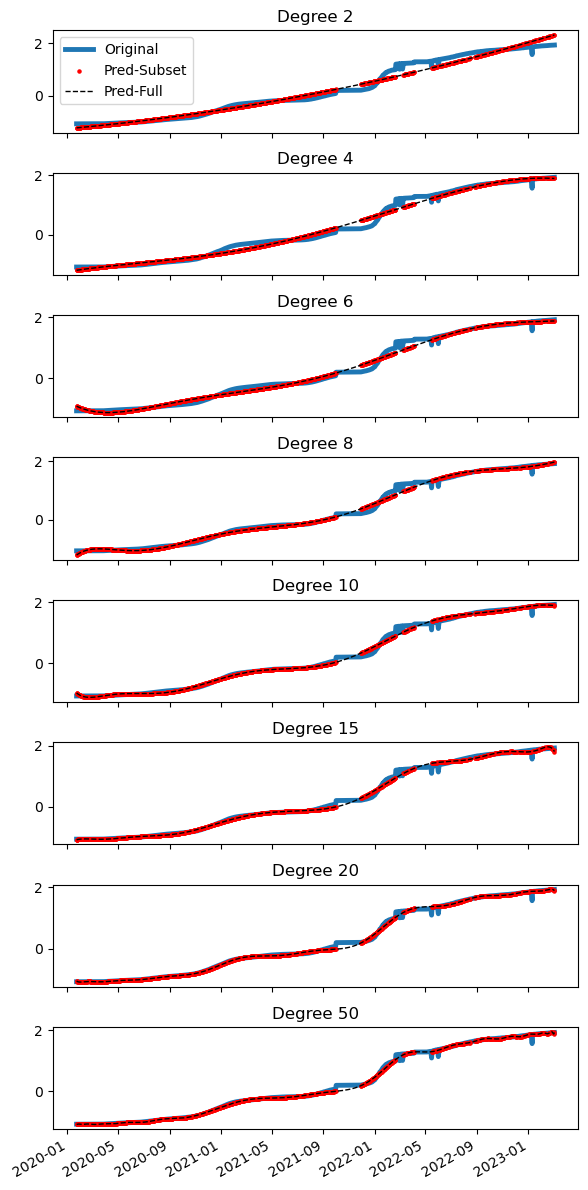

Text(0.5, 1.0, 'MSE vs poly order')

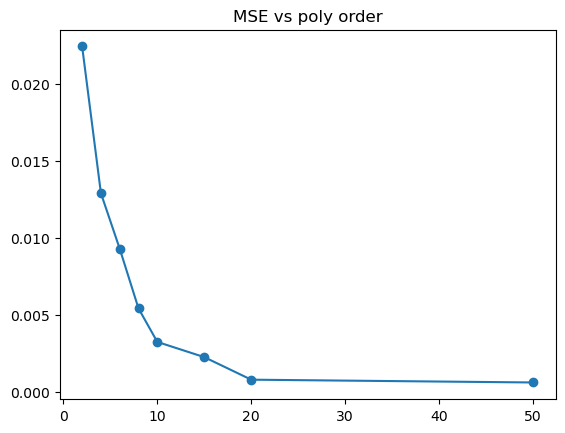

In [134]:
def fit_predict_poly(X_subset, y_subset, X_full, degree=2):

    # init poly feature builder
    poly = PolynomialFeatures(degree=degree)
    
    # build polynomial features from raw X
    X_subset_polyfeat = poly.fit_transform(X_subset)
    X_full_polyfeat = poly.transform(X_full)

    # create model and fit
    model = LinearRegression()
    model.fit(X_subset_polyfeat, y_subset)

    # Get preds for full and subset
    pred_y_subset = model.predict(X_subset_polyfeat)
    pred_y_full = model.predict(X_full_polyfeat)
    return pred_y_subset, pred_y_full


degrees = [2,4,6,8,10,15,20,50]
fig, axes = plt.subplots(len(degrees),1,figsize=(6,12),dpi=100)
mse_vals = []
for i, deg in enumerate(degrees):
    pred_y_not_na, pred_y_full = fit_predict_poly(not_na_X_scaled,
                                                  not_na_y_scaled,
                                                  full_X_scaled,
                                                  degree=deg)
    axes[i].plot(orig_times, orig_y_scaled, lw=3.5, label='Original', zorder=1)
    axes[i].scatter(not_na_times, pred_y_not_na, label='Pred-Subset', s=5, c='red')#ls='dashed', c='red')
    axes[i].plot(full_times, pred_y_full, lw=1, label='Pred-Full', ls='dashed', c='black')
    axes[i].set_title( f'Degree {deg}' )    
    mse_vals.append( mse(not_na_y_scaled, pred_y_not_na) )
axes[0].legend()
fig.autofmt_xdate()
fig.tight_layout()
plt.show()
plt.close()


plt.plot( degrees, mse_vals, marker='o' )
plt.title('MSE vs poly order')

### Random Forests

Next is Random Forests

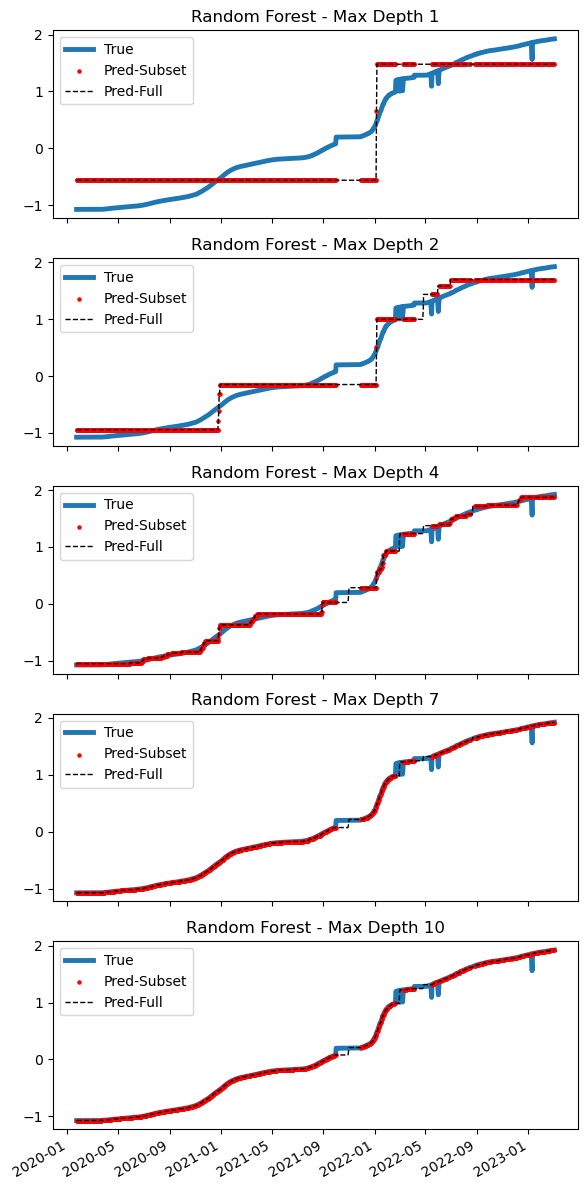

Text(0.5, 1.0, 'MSE vs RF Depth')

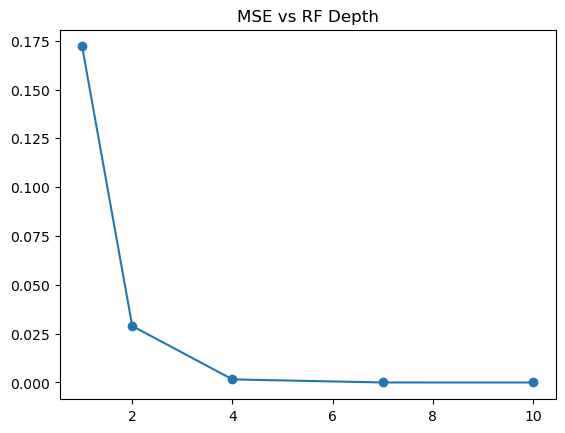

In [133]:
def fit_predict_rf(X_subset, y_subset, X_full, n_estimators=5, max_depth=None):
    # create model and fit on subset
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=rng_seed)
    model.fit(X_subset, y_subset)
    
    # get preds for subset and full
    pred_y_subset = model.predict(X_subset)
    pred_y_full = model.predict(X_full)
    
    return pred_y_subset, pred_y_full


max_depths = [1, 2, 4, 7, 10]
fig, axes = plt.subplots(len(max_depths), 1, figsize=(6, 12), dpi=100)
mse_vals = []
for i, max_depth in enumerate(max_depths):
    pred_y_not_na, pred_y_full = fit_predict_rf(not_na_X_scaled,
                                                not_na_y_scaled,
                                                full_X_scaled,
                                                max_depth=max_depth)
    axes[i].plot(orig_times, orig_y_scaled, lw=3.5, label='Original', zorder=1)
    axes[i].scatter(not_na_times, pred_y_not_na, label='Pred-Subset', s=5, c='red')#ls='dashed', c='red')
    axes[i].plot(full_times, pred_y_full, lw=1, label='Pred-Full', ls='dashed', c='black')
    axes[i].set_title(f'Random Forest - Max Depth {max_depth}')
    axes[i].legend()
    mse_vals.append( mse(not_na_y_scaled, pred_y_not_na) )
fig.autofmt_xdate()
fig.tight_layout()
plt.show()
plt.close()


plt.plot(max_depths, mse_vals, marker='o')
plt.title('MSE vs RF Depth')

Increasing the depth for each decision tree of the RF, the number of splits in which piecewise linear fitting is done grows as seen in the plots. But it does not generalize well to the gaps.

### KNN Regression

Now for K-Nearest-Neighbors regression

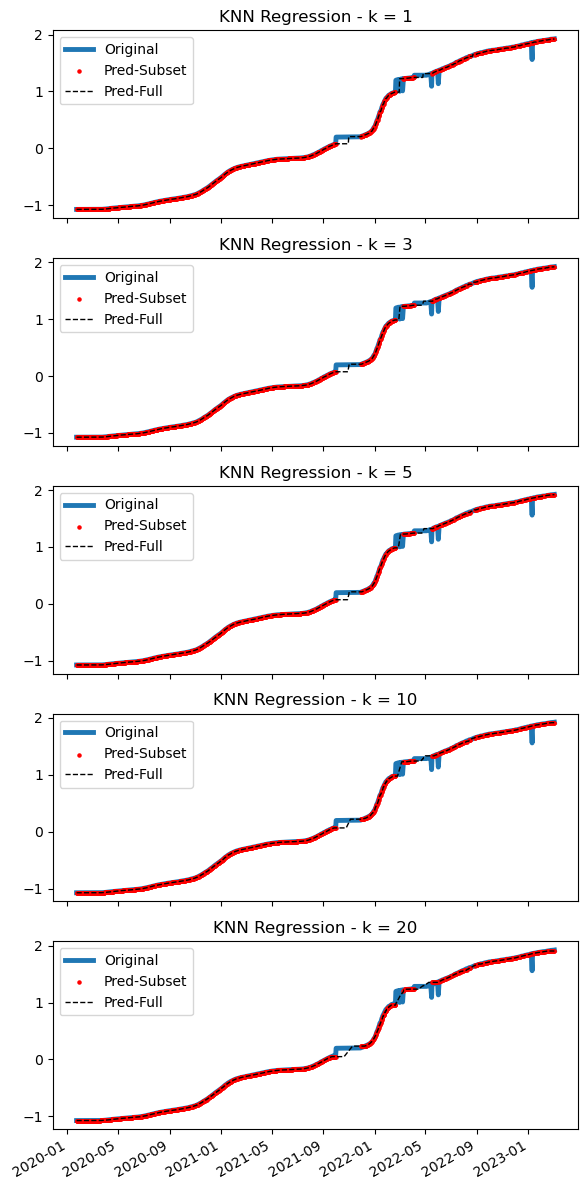

Text(0.5, 1.0, 'MSE vs number neighbors')

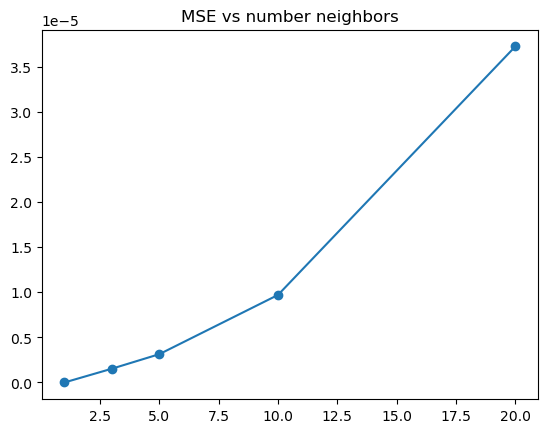

In [135]:
def fit_predict_knn(X_subset, y_subset, X_full, n_neighbors=5):
    # create and fit knn
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(X_subset, y_subset)
    
    # Get preds for full and subset
    pred_y_subset = model.predict(X_subset)
    pred_y_full = model.predict(X_full)
    
    return pred_y_subset, pred_y_full


# Train KNN
k_values = [1, 3, 5, 10, 20]
fig, axes = plt.subplots(len(k_values), 1, figsize=(6, 12), dpi=100)
mse_vals = []
for i, k in enumerate(k_values):
    pred_y_not_na, pred_y_full = fit_predict_knn(not_na_X_scaled,
                                                 not_na_y_scaled,
                                                 full_X_scaled,
                                                 n_neighbors=k)
    axes[i].plot(orig_times, orig_y_scaled, lw=3.5, label='Original', zorder=1)
    axes[i].scatter(not_na_times, pred_y_not_na, label='Pred-Subset', s=5, c='red')#ls='dashed', c='red')
    axes[i].plot(full_times, pred_y_full, lw=1, label='Pred-Full', ls='dashed', c='black')
    axes[i].set_title(f'KNN Regression - k = {k}')
    axes[i].legend()
    mse_vals.append(mse(not_na_y_scaled, pred_y_not_na))
fig.autofmt_xdate()
fig.tight_layout()
plt.show()
plt.close()

# Plot MSE values as a function of k-values
plt.plot(k_values, mse_vals, marker='o')
plt.title('MSE vs number neighbors')

Not surprising that it performs so well, since the all defined data is accessible to KNN - but it doesn't interpolate that well in the gaps.

### Gaussian Process

For a GP, we actually shouldn't use the 'confirmed' data directly because there's an assumption - the number of confirmed cases is monotonically increasing! This was not a problem in RF and KNN due to the method of how the predictions are done (but was technically a problem with polynomial regression since the higher order terms created higher frequency oscillations), but this can be a bigger problem with this method.

Instead, we'll compute the point-to-point different of confirmed cases (computing it ourselves instead of using the 'confirmed_change' column) then look at the log scale.

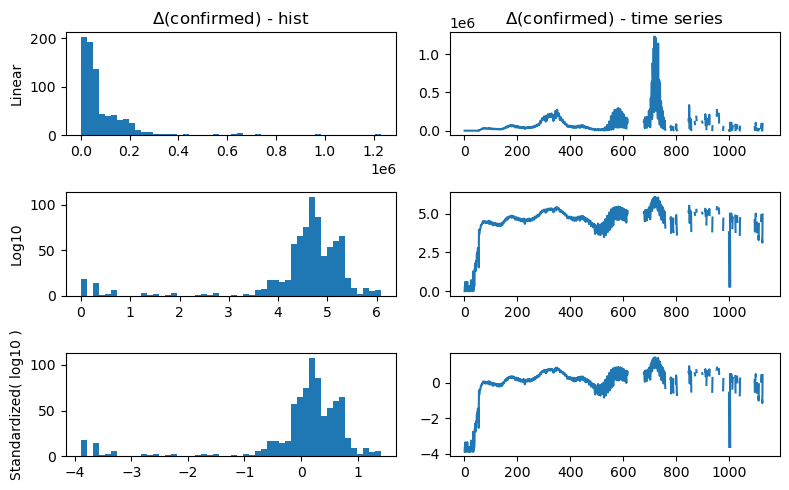

In [171]:
merged_df['delta_confirmed'] = np.hstack( [ np.nan, np.diff(merged_df['confirmed']) ] )
mask = (~merged_df['delta_confirmed'].isna()) & (merged_df['delta_confirmed'] > 0)
merged_df['ldc'] = np.log10(merged_df['delta_confirmed'].values + 1)

delta_confirmed_scaler = StandardScaler().fit( merged_df[['ldc']].dropna() )
merged_df['stand_ldc'] = delta_confirmed_scaler.fit_transform( merged_df[['ldc']] ).flatten()

# plot consec diffs - linear then log10
fig, axes = plt.subplots(3,2,figsize=(8,5), dpi=100)

axes[0,0].set_title('$\Delta$(confirmed) - hist')
axes[0,0].hist( merged_df['delta_confirmed'], bins=50 )
axes[1,0].hist( merged_df['ldc'], bins=50 )
axes[2,0].hist( merged_df['stand_ldc'], bins=50 )

axes[0,1].set_title('$\Delta$(confirmed) - time series')
axes[0,1].plot( merged_df['delta_confirmed'] )
axes[1,1].plot( merged_df['ldc'] )
axes[2,1].plot( merged_df['stand_ldc'] )

axes[0,0].set_ylabel('Linear')
axes[1,0].set_ylabel('Log10')
axes[2,0].set_ylabel('Standardized( log10 )')
fig.tight_layout()

We'll now try to model a GP on this standardized log-scaled of the differences, then add these back up to get a number of confirmed cases - a little sketchy, but we'll see what the results look like!

The time series is a little noisy, so we'll run a median (not mean!) filter to get a lower frequency curve, then train the GP on that. We'll try a number of window sizes (including size 1, meaning raw).

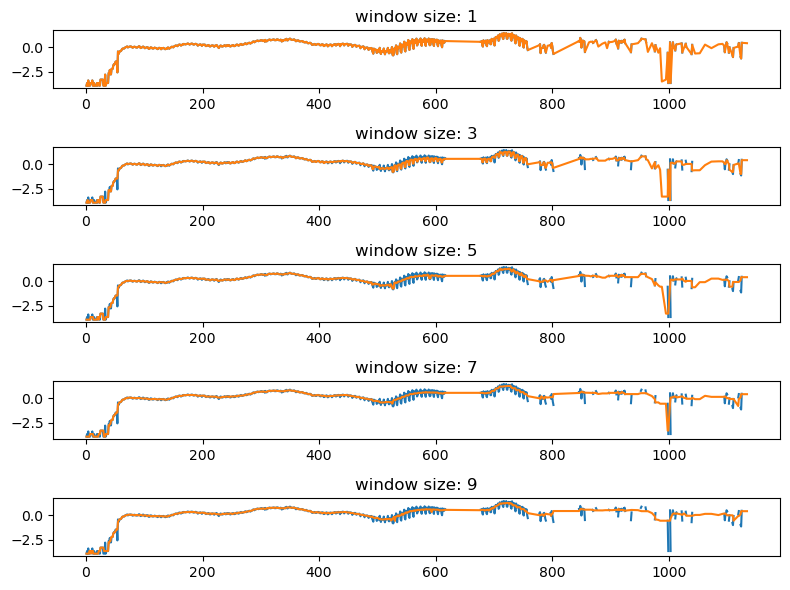

In [182]:
contiguous = merged_df['stand_ldc'].dropna()

sizes = [1, 3, 5, 7, 9]
fig, axes = plt.subplots(len(sizes),1, figsize=(8,6))
filtered_ys = []
for i, size_i in enumerate(sizes):
    LD_smoothed = median_filter(contiguous, size=size_i)
    filtered_ys.append( LD_smoothed )
    axes[i].plot( merged_df.index, merged_df['stand_ldc'])
    axes[i].plot( contiguous.index, LD_smoothed )
    axes[i].set_title(f'window size: {size_i}')
fig.tight_layout()

5it [06:45, 81.09s/it] 


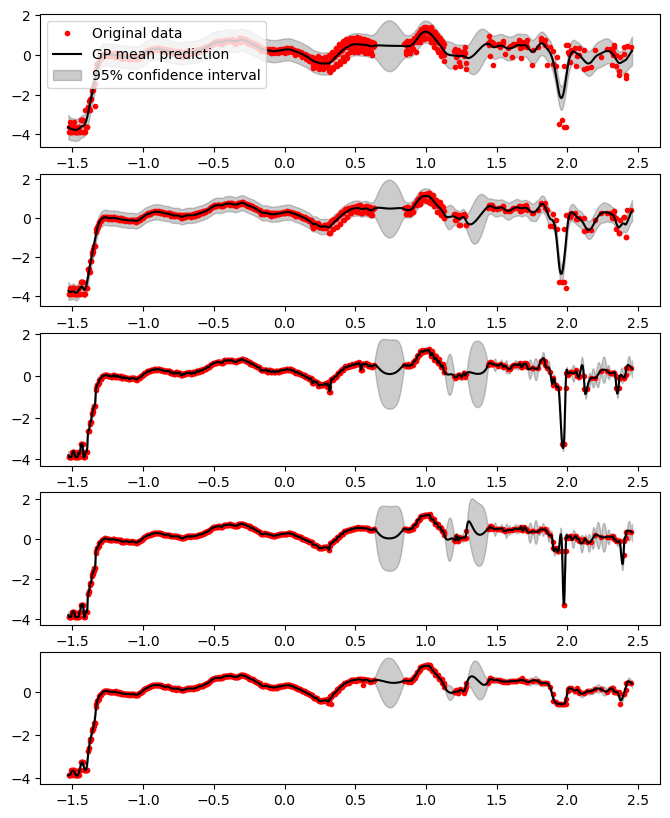

Text(0.5, 1.0, 'Window size vs GP-LML')

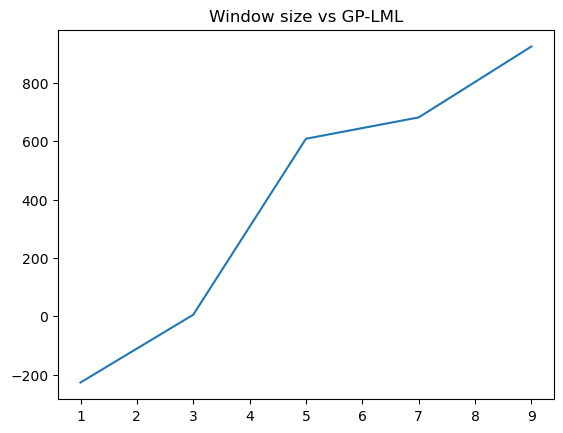

In [199]:
# Build the kernel for the GP
kernel = (C(1.0, (1e-4, 1e1)) 
          * Matern(length_scale=0.1, nu=1.5)
          + WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-10, 1e1)) )

# get scaled input
x_not_na = LD_contiguous.index.values
x_full = merged_df.index.values
confirmed_scaler = StandardScaler().fit( x_not_na.reshape(-1,1) )
x_not_na_scaled = confirmed_scaler.transform( x_not_na.reshape(-1,1) )
x_full_scaled = confirmed_scaler.transform( x_full.reshape(-1,1) )


# train separate GP per window size
fig, axes = plt.subplots(len(filtered_ys),1,figsize=(8,10))
gps = []
for i, gp_y in tqdm( enumerate(filtered_ys) ):

    # init gp and save
    gp_confirmed = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-5)
    gps.append( gp_confirmed )
    
    # train gp
    gp_confirmed.fit( x_not_na_scaled,
                      gp_y )

    # get *full* predictions
    y_pred, sigma = gp_confirmed.predict( 
                        x_full_scaled,
                        return_std=True
    )

    # Show original data, mean predictions, and 2-sigma envelope
    axes[i].plot(x_not_na_scaled.flatten(),
                 gp_y,
                 'r.', label="Original data")
    axes[i].plot(x_full_scaled.flatten(), 
                 y_pred, 'k-', label="GP mean prediction")
    axes[i].fill_between(x_full_scaled.flatten(),
                         y_pred - 1.96 * sigma,
                         y_pred + 1.96 * sigma, 
                         alpha=0.2, color='k', label="95% confidence interval")

axes[0].legend(loc='upper left')
plt.show()

# show log marginal likelihood for each gp
plt.plot(sizes, [ gp.log_marginal_likelihood() for gp in gps ], marker='o')
plt.title('Window size vs GP-LML')

Providing more noise-free data causes the standard deviation of the subsequent GPs to diminish over the intervals to impute, not surprising.

In [200]:
for i, gp in enumerate(gps):
    print('--- For window size:',sizes[i],'---\n'
          'Original kernel:',gp.kernel,'\n',
          'Trained kernel:',gp.kernel_)

--- For window size: 1 ---
Original kernel: 1**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.1) 
 Trained kernel: 0.987**2 * Matern(length_scale=0.143, nu=1.5) + WhiteKernel(noise_level=0.0744)
--- For window size: 3 ---
Original kernel: 1**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.1) 
 Trained kernel: 0.972**2 * Matern(length_scale=0.104, nu=1.5) + WhiteKernel(noise_level=0.035)
--- For window size: 5 ---
Original kernel: 1**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.1) 
 Trained kernel: 0.853**2 * Matern(length_scale=0.0435, nu=1.5) + WhiteKernel(noise_level=0.00185)
--- For window size: 7 ---
Original kernel: 1**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.1) 
 Trained kernel: 0.828**2 * Matern(length_scale=0.0375, nu=1.5) + WhiteKernel(noise_level=0.000707)
--- For window size: 9 ---
Original kernel: 1**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.1) 
 Trained kernel: 0.866**2 * 

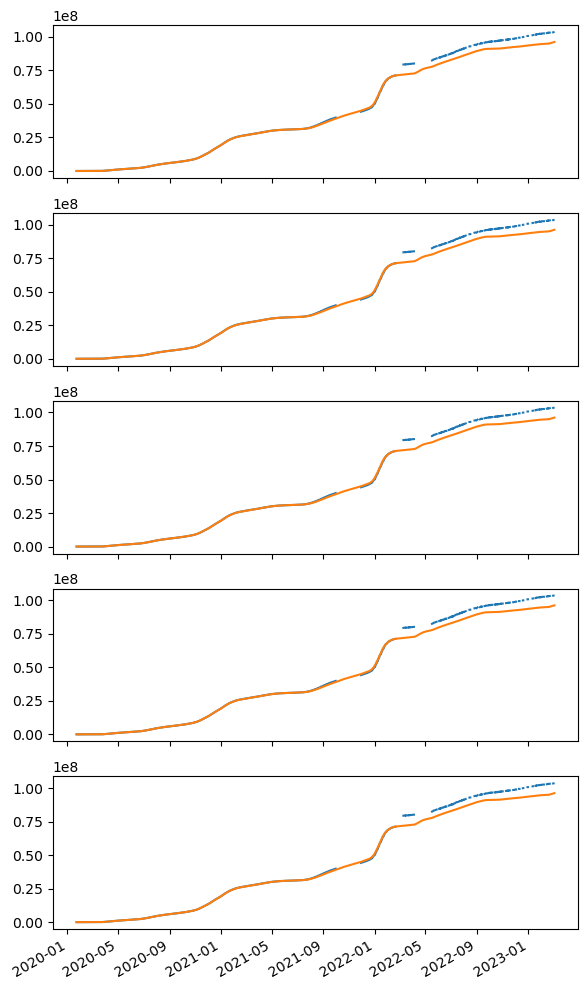

In [201]:
fig, axes = plt.subplots(len(gps),1,figsize=(6,10))
for i, gp in enumerate(gps):
    # get full predictions
    full_y_preds, sigma = gp_confirmed.predict( x_full_scaled, return_std=True )
    # undo scaling...
    descaled_preds = delta_confirmed_scaler.inverse_transform( full_y_preds.reshape(-1,1) ).flatten()
    # and 1-shifted log10 transform, then do cumulative sum
    confirmed_preds = np.cumsum(10**(descaled_preds) - 1)

    axes[i].plot(merged_df['updated'], merged_df['confirmed'])
    axes[i].plot(merged_df['updated'], confirmed_preds)    

fig.autofmt_xdate()
fig.tight_layout()

Since we're summing the antilog of the predictions, the results in linear scale are unfortunately difficult to distinguish from each other... Nevertheless, while the first large interval is imputed well, the second and third large intervals not so much. 